# Dec 9th, 2021 (tSNR: BOLD)

**Motivation**: temporal SNR for BOLD <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [82]:
# HIDE CODE


def _load(mice, key, which: str = 'both', raw_bold: bool = False):
    if which == 'both':
        which = ['ca2', 'bold']
    else:
        which = [which]
    sub, ses, _ = mice.looper[key]
    
    if 'ca2' in which:
        m2d = mice.mask2d[mice.get_key(sub, ses)]
        m2d = m2d.load_ants().numpy().astype(bool)
        x2d = mice.ca_preproc[key][:]
        if x2d is None:
            out2d = None
        else:
            mu2d = x2d.mean(-1)
            sd2d = x2d.std(-1)
            snr2d = mu2d / sd2d
            out2d = {
                'm': m2d,
                'x': x2d,
                'gs': x2d[m2d].mean(0),
                'mu_abs': np.abs(x2d).mean(-1),
                'mu': mu2d,
                'sd': sd2d,
                'snr': snr2d,
                'snr_avg': bn.nanmean(snr2d[m2d]),
            }
    else:
        out2d = None

    if 'bold' in which:
        m3d = mice.mask3d[mice.get_key(sub, ses)]
        m3d = m3d.load_ants().numpy().astype(bool)
        if raw_bold:
            try:
                file = next(
                    f for f in os.listdir(mice.cfg.npy_dir) if
                    all(e in f for e in [key, 'space-individual_desc-raw'])
                )
                file = pjoin(mice.cfg.npy_dir, file)
                x3d = np.load(file)
            except StopIteration:
                x3d = None
        else:
            x3d = mice.bold_preproc[key][:]
        if x3d is None:
            out3d = None
        else:
            mu3d = x3d.mean(-1)
            sd3d = x3d.std(-1)
            snr3d = mu3d / sd3d
            out3d = {
                'm': m3d,
                'x': x3d,
                'gs': x3d[m3d].mean(0),
                'mu_abs': np.abs(x3d).mean(-1),
                'mu': mu3d,
                'sd': sd3d,
                'snr': snr3d,
                'snr_avg': bn.nanmean(snr3d[m3d]),
            }
    else:
        out3d = None
        
    return out2d, out3d


def plot_1(gs2d, gs3d, key, nb_stds=2, ab=None, chunk_size=300, alpha=0.2):

    num = int(600 / chunk_size)
    nrows = 2 * (num + 1)

    fig, axes = create_figure(nrows, 1, (13.5, 2 * nrows),
                              gridspec_kw={'height_ratios': [1.5] * 2 + [1] * num * 2})
    axes[0].plot(gs2d, color='g')
    axes[1].plot(gs3d, color='r')
    
    sd = bn.nanstd(gs2d)
    axes[0].axhspan(- nb_stds * sd, nb_stds * sd, color='gold', lw=3, alpha=alpha)
    axes[0].axhline(- (nb_stds + 1) * sd, color='gold', ls='--')
    axes[0].axhline((nb_stds + 1) * sd, color='gold', ls='--')
    sd = bn.nanstd(gs3d)
    axes[1].axhspan(- nb_stds * sd, nb_stds * sd, color='gold', lw=3, alpha=alpha)
    axes[1].axhline(- (nb_stds + 1) * sd, color='gold', ls='--')
    axes[1].axhline((nb_stds + 1) * sd, color='gold', ls='--')
    
    if ab is not None:
        a, b = ab
        axes[0].axvspan(a * 10, b * 10, color='magenta', alpha=0.3)
        axes[1].axvspan(a, b, color='magenta', alpha=0.3)

    for i in range(1, num + 1):
        start = (i - 1) * chunk_size
        end = i * chunk_size
        intvl = range(start * 10, min(end * 10, len(gs2d)))
        axes[2 * i].plot(intvl, gs2d[intvl], color='dimgrey')

        intvl = range(start, min(end, len(gs3d)))
        axes[2 * i + 1].plot(intvl, gs3d[intvl], color='k')
        
        sd = bn.nanstd(gs2d[intvl])
        axes[2 * i].axhspan(- nb_stds * sd, nb_stds * sd, color='gold', alpha=alpha)
        sd = bn.nanstd(gs3d[intvl])
        axes[2 * i + 1].axhspan(- nb_stds * sd, nb_stds * sd, color='gold', alpha=alpha)
        

    for i in range(2):
        axes[2 * i].axvspan(0, 50 * 10, color='dimgrey', alpha=0.3)
        axes[2 * i + 1].axvspan(0, 50, color='dimgrey', alpha=0.3)

    fig.suptitle(f"plot #1, {key}", fontsize=14, y=1.02)
    plt.show()
    
    return fig, axes


def plot_2(out2d, key, threshold=0.05):
    xlist = [out2d['mu_abs'], out2d['mu'], out2d['sd'], out2d['snr'], out2d['m']]
    mu_abs, mu, sd, snr, m = filter_boundaries(xlist, out2d['m'])
    snr = np.abs(snr)
    
    fig1, axes = create_figure(1, 4, (13, 3.2), gridspec_kw={'width_ratios': [1, 1, 1, 1.5]})

    im = axes[0].imshow(mu_abs, cmap='Spectral')
    plt.colorbar(im, ax = axes[0], shrink=0.7)

    im = axes[1].imshow(mu, cmap='Spectral')
    plt.colorbar(im, ax = axes[1], shrink=0.7)

    im = axes[2].imshow(sd, cmap='Spectral')
    plt.colorbar(im, ax = axes[2], shrink=0.7)

    im = axes[3].imshow(snr, cmap='Spectral')
    plt.colorbar(im, ax = axes[3])

    axes[0].set_title(r'$\mu$ (abs)')
    axes[1].set_title(r'$\mu$')
    axes[2].set_title(r'$\sigma$')
    axes[3].set_title(r'tSNR $ = abs(\mu / \sigma)$')
    fig1.suptitle(f"plot #2, {key}", fontsize=14, y=1.02)
    remove_ticks(axes)
    plt.show()
    
    fig2, axes = create_figure(1, 2, (12, 2.7))

    vals = snr[np.logical_and(m, np.isfinite(snr))]
    vals = np.abs(vals)
    q = np.quantile(vals, threshold)
    sns.histplot(vals, ax=axes[0])
    axes[0].axvline(q, color='r', ls='--')
    axes[1].imshow(snr > q)
    remove_ticks(axes[1])
    plt.show()
    
    gs_good = out2d['x'][np.logical_and(out2d['m'], np.abs(out2d['snr']) > q)].mean(0)
    gs_bad = out2d['x'][np.logical_and(out2d['m'], np.abs(out2d['snr']) <= q)].mean(0)
    
    fig3, ax = create_figure(1, 1, (13, 4), sharex='all', sharey='all')
    ax.plot(gs_bad, color='r', lw=0.7, label='gs bad')
    ax.plot(gs_good, color='k', lw=0.9, label='gs good')
    ax.legend(fontsize='large')
    ax.grid()
    plt.show()
    
    return fig1, fig2, fig3


def plot_3(out3d, key, display: bool = True, threshold=0.05, slice_ids=None):
    slice_ids = slice_ids if slice_ids else [10, 20, 30, 40]
    snr = np.abs(out3d['snr'])
    
    fig1, axes = create_figure(
        3, len(slice_ids) + 1, figsize=(13, 6.),
        gridspec_kw={'width_ratios': [1] * len(slice_ids) + [1.6]})

    for i in range(3):
        for j, s in enumerate(slice_ids):
            x2plt = np.take(snr, s, axis=i)
            if i == 2:
                x2plt = x2plt.T
            im = axes[i, j].imshow(x2plt, cmap='Spectral')
            plt.colorbar(im, ax=axes[i, j], shrink=0.7)
        x2plt = bn.nanmean(snr, axis=i)
        x2plt = filter_boundaries(x2plt, out3d['m'].mean(i).astype(bool))
        if i == 2:
            x2plt = x2plt.T
        im = axes[i, -1].imshow(x2plt, cmap='Spectral')
        plt.colorbar(im, ax=axes[i, -1], shrink=0.7)
        fig1.suptitle(f"plot #3, {key}", fontsize=14, y=1.01)

    remove_ticks(axes)
    plt.show()

    fig2, axes = create_figure(1, 4, (13, 2.7))

    vals = out3d['snr'][np.logical_and(out3d['m'], np.isfinite(out3d['snr']))]
    vals = np.abs(vals)
    q = np.quantile(vals, threshold)
    above = out3d['snr'] > q
    sns.histplot(vals, ax=axes[0])
    axes[0].axvline(q, color='r', ls='--')
    for i in range(1, 4):
        x2plt = above.mean(i - 1)
        if i == 3:
            x2plt = x2plt.T
        axes[i].imshow(x2plt)
        remove_ticks(axes[i])
    plt.show()

    return fig1, fig2


def plot_4(mice, sub, ses, brief: bool = True, display: bool = True, threshold=0.05):
    data = []
    for run in mice.cfg.run_ids:
        key = mice.get_key(sub, ses, run)
        out2d, _ = _load(mice, key, 'ca2')

        snr, m = filter_boundaries([out2d['snr'], out2d['m']], out2d['m'])
        vals = snr[np.logical_and(m, np.isfinite(snr))]
        vals, snr = np.abs(vals), np.abs(snr)
        q = np.quantile(vals, threshold)

        data.append((snr, m, vals, q))

    if brief:
        nrows = 2
        fig, axes = create_figure(
            nrows=nrows,
            ncols=len(data),
            figsize=(13, 2 * nrows),
        )
        for i in range(len(data)):
            snr, _, _, q = data[i]
            axes[0, i].imshow(snr, cmap='Spectral')
            axes[1, i].imshow(snr > q)
            axes[0, i].set_title(f"run # {i+1}", y=1.03)
        remove_ticks(axes)
        sup = f"{mice.get_key(sub, ses)} / temporal SNR = "
        sup += r'$\mu / \sigma$'
        sup = fig.suptitle(sup, fontsize=14, y=1.03)
    
    else:
        ncols = 6
        nrows = int(np.ceil(len(data) / 2))
        fig, axes = create_figure(
            nrows=nrows,
            ncols=ncols,
            figsize=(13, 2. * nrows),
            gridspec_kw={'width_ratios': [1.4, 1, 1.2] * 2},
        )
        for i in range(nrows):
            for j in range(2):
                idx = 2 * i + j
                try:
                    snr, m, vals, q = data[idx]
                except IndexError:
                    continue

                im = axes[i, 3 * j].imshow(snr, cmap='Spectral')
                plt.colorbar(im, ax=axes[i, 3 * j], shrink=0.8)
                axes[i, 3 * j + 1].imshow(snr > q)
                sns.histplot(vals, ax=axes[i, 3 * j + 2])
                axes[i, 3 * j + 2].axvline(q, color='r', ls='--', lw=1, label=f"q = {q:0.3f}")
                axes[i, 3 * j + 2].legend()
                axes[i, 3 * j + 2].grid()
                remove_ticks(axes[i, :2])
                remove_ticks(axes[i, 3:5])
        remove_ticks(axes.flat[-1])
        sup = f"{mice.get_key(sub, ses)} / temporal SNR = "
        sup += r'$\mu / \sigma$'
        sup = fig.suptitle(sup, fontsize=17, y=1.03)
        
    if display:
        plt.show()
    else:
        plt.close()
        
    return fig, sup, axes


def plot_5(mice, sub, ses, display: bool = True, threshold=0.05):
    data = {}
    for run in mice.cfg.run_ids:
        key = mice.get_key(sub, ses, run)
        _, out3d = _load(mice, key, 'bold', raw_bold=True)
        if out3d is None:
            continue

        snr, m = out3d['snr'], out3d['m']
        vals = snr[np.logical_and(m, np.isfinite(snr))]
        vals, snr = np.abs(vals), np.abs(snr)
        q = np.quantile(vals, threshold)

        data[run] = (snr, m, vals, q)

    nrows = len(data)
    fig, axes = create_figure(nrows, 4, (13, 2.2 * nrows), gridspec_kw={'width_ratios': [1.8, 1, 1, 1]})
    for i in range(nrows):
        snr, m, vals, q = data[i + 1]
        sns.histplot(vals, ax=axes[i, 0])
        axes[i, 0].axvline(q, color='r', ls='--', lw=0.9, label=f"q = {q:0.3f}")
        axes[i, 0].set_ylabel(f"run # {i + 1}\n", fontsize=13)
        axes[i, 0].legend()
        
        above = snr > q
        for j in range(1, 4):
            x2plt = above.mean(j - 1)
            if j == 3:
                x2plt = x2plt.T
            axes[i, j].imshow(x2plt)
            remove_ticks(axes[i, j])
    sup = f"{mice.get_key(sub, ses)} (bold) / temporal SNR = "
    sup += r'$\mu / \sigma$'
    sup = fig.suptitle(sup, fontsize=17, y=1.03)
    
    if display:
        plt.show()
    else:
        plt.close()
    
    return fig, sup, axes

In [3]:
mice = Mice((768, 4))
mice.setup_func_data('rest', bold_gsr=False)
mice.setup_preproc_data(bold_gsr=False)
mice.setup_anat_data()

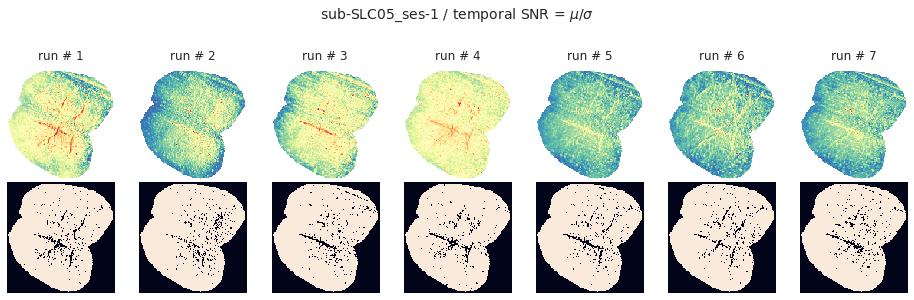

CPU times: user 51.9 s, sys: 2min 1s, total: 2min 53s
Wall time: 6min 42s


In [4]:
%%time
fig, sup, axes = plot_4(mice, 5, 1, brief=True, display=True)

In [26]:
key = 'sub-SLC05_ses-1_run-3'
_, out3d = _load(mice, key, 'bold', True)

[<matplotlib.lines.Line2D object at 0x7ef35d5cfdf0>]

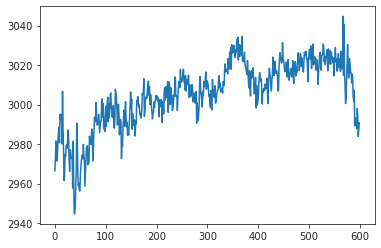

In [28]:
plt.plot(out3d['gs'])

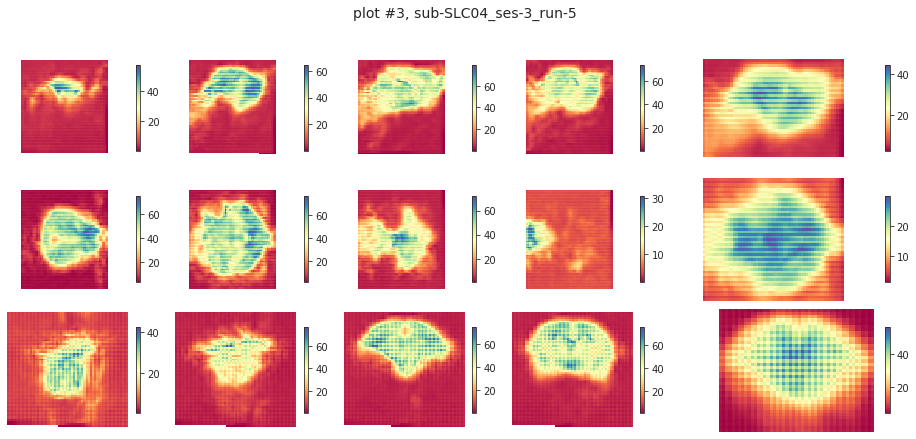

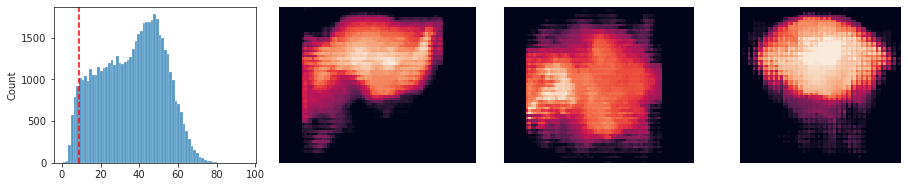

In [42]:
key = 'sub-SLC04_ses-3_run-5'
_, out3d = _load(mice, key, 'bold', True)
_ = plot_3(out3d, key)

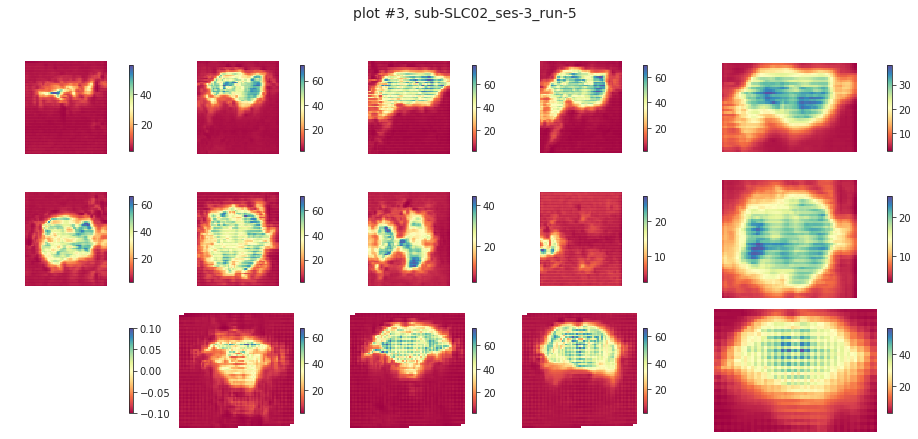

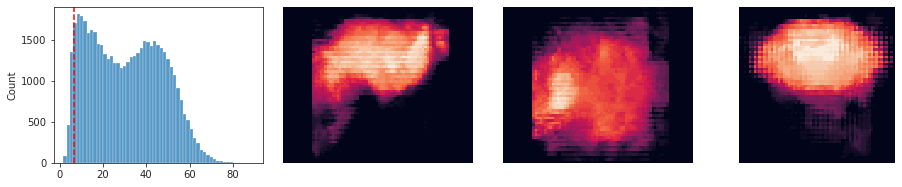

In [43]:
key = 'sub-SLC02_ses-3_run-5'
_, out3d = _load(mice, key, 'bold', True)
_ = plot_3(out3d, key)

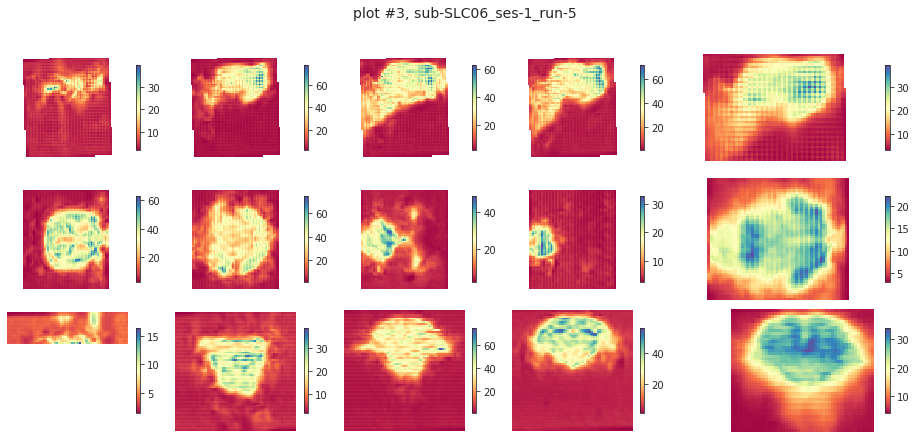

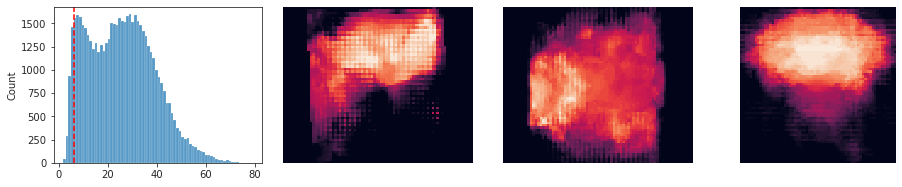

In [44]:
key = 'sub-SLC06_ses-1_run-5'
_, out3d = _load(mice, key, 'bold', True)
_ = plot_3(out3d, key)

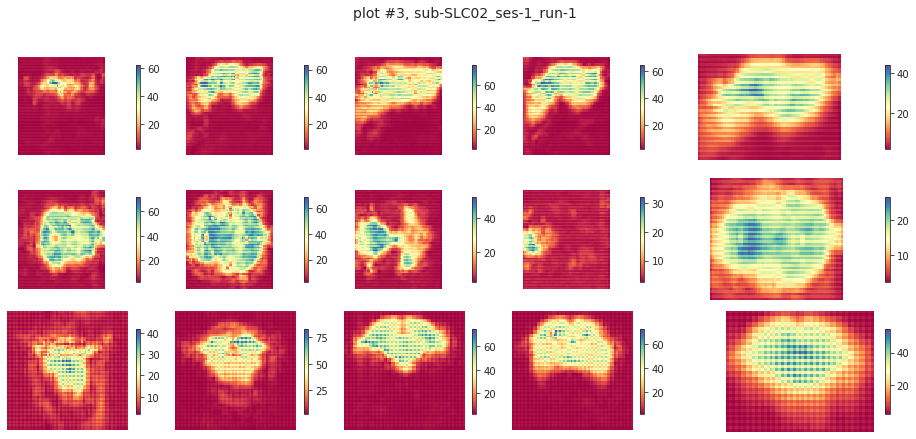

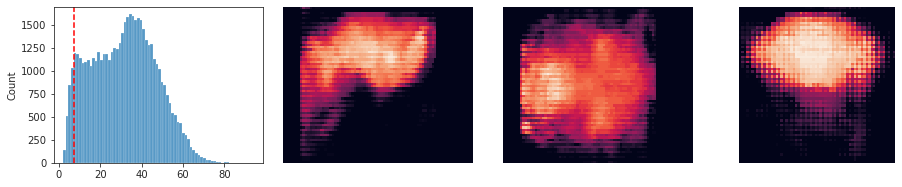

In [45]:
key = 'sub-SLC02_ses-1_run-1'
_, out3d = _load(mice, key, 'bold', True)
_ = plot_3(out3d, key)

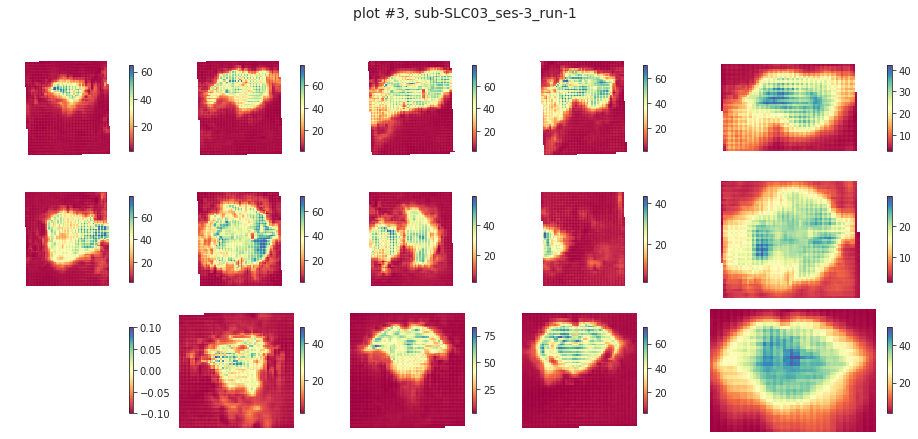

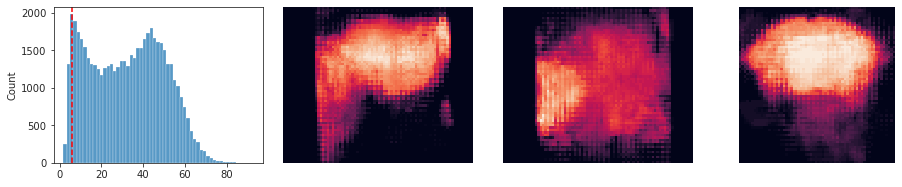

In [46]:
key = 'sub-SLC03_ses-3_run-1'
_, out3d = _load(mice, key, 'bold', True)
_ = plot_3(out3d, key)

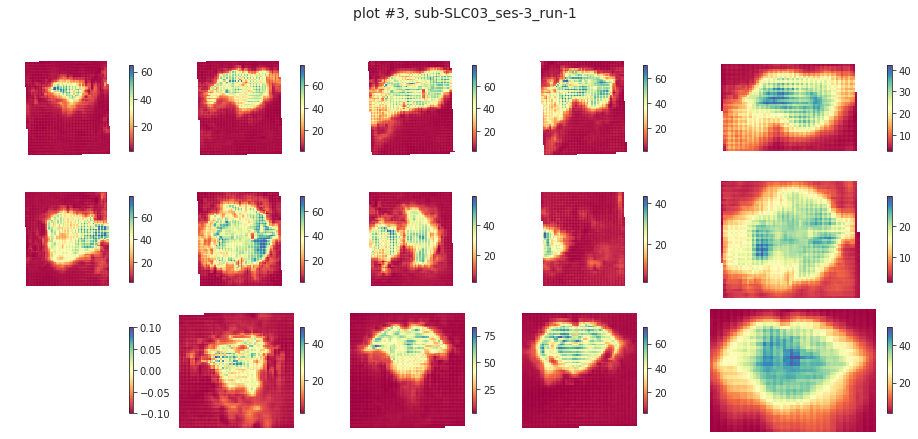

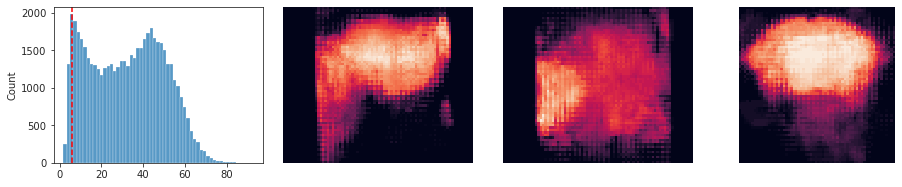

In [48]:
_, out3d = _load(mice, key, 'bold', True)
f1, f2 = plot_3(out3d, key, False)

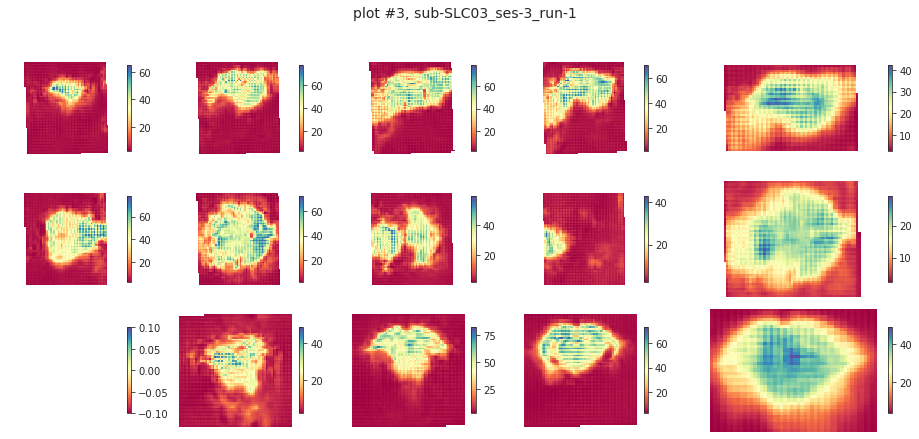

In [49]:
f1

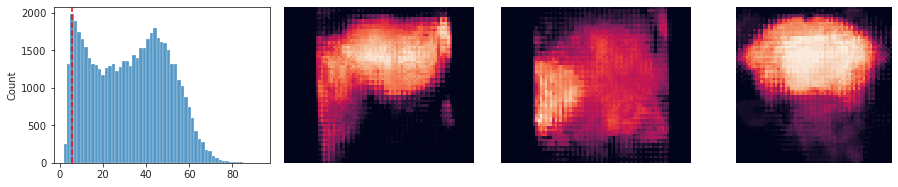

In [50]:
f2

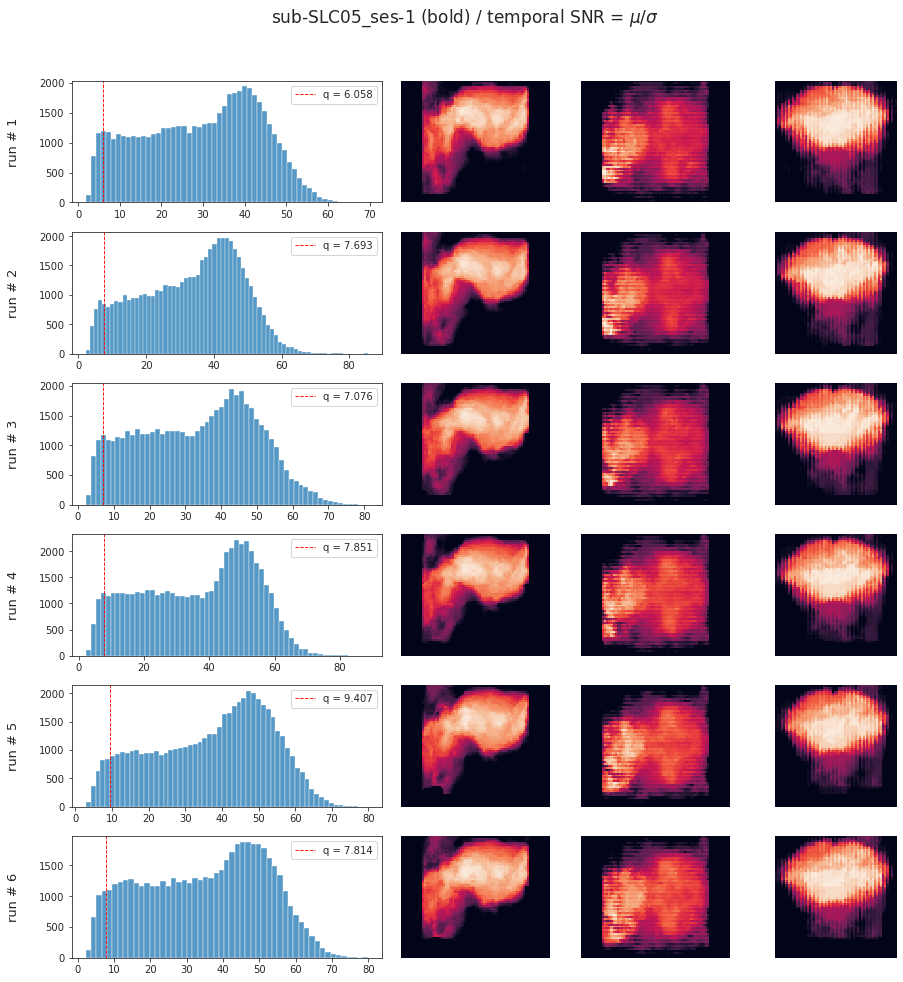

CPU times: user 16.4 s, sys: 52.9 s, total: 1min 9s
Wall time: 1min 32s


In [83]:
%%time

fig, sup, _ = plot_5(mice, 5, 1)

In [84]:
%%time

figs, sups = [], []
for sub in mice.cfg.sub_ids:
    for ses in mice.cfg.ses_ids:
        try:
            fig, sup, _ = plot_5(mice, sub, ses, display=False)
            figs.append(fig)
            sups.append(sup)
        except (TypeError, KeyError):
            continue

CPU times: user 8min 8s, sys: 25min 45s, total: 33min 54s
Wall time: 1h 17min 7s


In [85]:
save_fig(
    fig=figs,
    sup=sups,
    save_file=pjoin(tmp_dir, 'tsnr_bold.pdf'),
    display=False,
    multi=True,
)

## In common space

In [87]:
key = 'sub-SLC03_ses-3_run-1'

file = next(
    f for f in os.listdir(mice.cfg.npy_dir) if
    all(e in f for e in [key, 'space-N162_desc-raw'])
)
file = pjoin(mice.cfg.npy_dir, file)
x3d = np.load(file)

<matplotlib.image.AxesImage object at 0x7ef2e3f9e310>

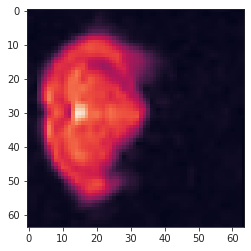

In [88]:
plt.imshow(x3d[..., 40, 120])

In [89]:
key = 'sub-SLC03_ses-3_run-1'

file = next(
    f for f in os.listdir(mice.cfg.npy_dir) if
    all(e in f for e in [key, 'space-N162_desc-raw'])
)
file = pjoin(mice.cfg.npy_dir, file)
x3d = np.load(file)

<matplotlib.colorbar.Colorbar object at 0x7ef2a3e9d1c0>

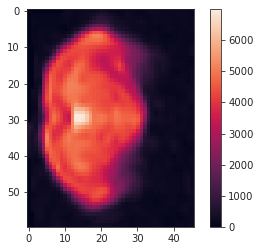

In [91]:
plt.imshow(x3d[..., 40, 120])
plt.colorbar()

<matplotlib.image.AxesImage object at 0x7ef2a3abcbe0>

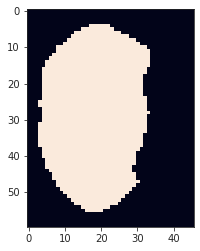

In [101]:
plt.imshow(x3d[..., 40, 120] > 1000)

In [107]:
mu = x3d.mean(-1)
sd = x3d.std(-1)
snr = mu / sd
snr.shape

(60, 46, 81)

<matplotlib.colorbar.Colorbar object at 0x7ef2a398f1f0>

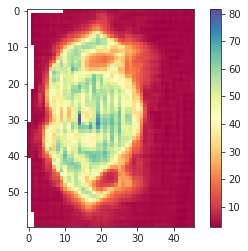

In [110]:
plt.imshow(snr[..., 40], cmap='Spectral')
plt.colorbar()